# Modelling miner behaviour

This is a fork of [@barnabemonnot](https://twitter.com/barnabemonnot)'s [EIP-1559 Stationary Behaviour model](https://github.com/barnabemonnot/abm1559/blob/master/notebooks/stationary1559.ipynb), built on a corresponding fork of his amb1559 package to investigate a range of possible miner strategies under EIP-1559.

In [1]:
import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
# Do not use the abm1559 package from pypi to run this script

from abm1559.utils import constants

from abm1559.txpool import TxPool, Strategy

from abm1559.users import User1559

from abm1559.userpool import UserPool

from abm1559.chain import (
    Chain,
    Block1559,
)

from abm1559.simulator import (
    spawn_poisson_demand,
    update_basefee,
)

import pandas as pd

And define the main function used to simulate the fee market.

In [13]:
def simulate(demand_scenario, UserClass, strategies=[Strategy()]):
    # Instantiate a couple of things
    txpool = TxPool()
    for s in strategies:
        txpool.add_strategy(s)
    basefee = constants["INITIAL_BASEFEE"]
    chain = Chain()
    metrics = []
    user_pool = UserPool()

    for t in range(len(demand_scenario)):
        if t % 100 == 0: print(t)

        # `params` are the "environment" of the simulation
        params = {
            "basefee": basefee,
            "current_block": t,
        }

        # We return a demand drawn from a Poisson distribution.
        # The parameter is given by `demand_scenario[t]`, and can vary
        # over time.
        users = spawn_poisson_demand(t, demand_scenario[t], UserClass)

        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, params)

        # New transactions are added to the transaction pool
        txpool.add_txs(decided_txs)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(params)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = basefee)

        # The block is added to the chain
        chain.add_block(block)

        # A couple of metrics we will use to monitor the simulation
        row_metrics = {
            "block": t,
            "basefee": basefee / (10 ** 9),
            "users": len(users),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "blk_avg_gas_price": block.average_gas_price(),
            "blk_avg_tip": block.average_tip(),
            "pool_length": txpool.pool_length,
        }
        metrics.append(row_metrics)

        # Finally, basefee is updated and a new round starts
        basefee = update_basefee(block, basefee)

    return (pd.DataFrame(metrics), user_pool, chain)

As you can see, `simulate` takes in a `demand_scenario` array. Earlier we mentioned that each round, we draw the number of users wishing to send transactions from a Poisson distribution. [This distribution is parameterised by the expected number of arrivals, called _lambda_ $\lambda$](https://en.wikipedia.org/wiki/Poisson_distribution). The `demand_scenario` array contains a sequence of such lambda's. We also provide in `UserClass` the type of user we would like to model (see the [docs](http://barnabemonnot.com/abm1559/build/html/#users) for more details).

Our users draw their _value_ for the transaction (per unit of gas) from a uniform distribution, picking a random number between 0 and 20 (Gwei). Their cost for waiting one extra unit of time is drawn from a uniform distribution too, this time between 0 and 1 (Gwei). The closer their cost is to 1, the more impatient users are.

Say for instance that I value each unit of gas at 15 Gwei, and my cost per round is 0.5 Gwei. If I wait for 6 blocks to be included at a gas price of 10 Gwei, my payoff is $15 - 6 \times 0.5 - 10 = 2$.

The numbers above sound arbitrary, and in a sense they are! They were chosen to respect the scales we are used to ([although gas prices are closer to 100 Gweis these days...](https://ethereum.github.io/rig/ethdata/notebooks/gas_weather_reports/exploreJuly21.html)). It also turns out that any distribution (uniform, Pareto, whatever floats your boat) leads to stationarity. The important part is that _some_ users have positive value for transacting in the first place, enough to fill a block to its target size at least. The choice of sample the cost from a uniform distribution, as opposed to having all users experience the same cost per round, allows for **simulating a scenario where some users are more in a hurry than others**.

In [3]:
demand_scenario = [2000 for i in range(200)]
(df, user_pool, chain) = simulate(demand_scenario, User1559)

0
100


To study the stationary case, we create an array repeating $\lambda$ for as many blocks as we wish to simulate the market for. We set $\lambda$ to spawn on average 2000 users between two blocks.

## Results

Let's print the head and tail of the data frame holding our metrics. Each row corresponds to one round of our simulation, so one block.

In [4]:
df

,block,basefee,users,decided_txs,included_txs,blk_avg_gas_price,blk_avg_tip,pool_length
0,0,1.000000,2012,1565,952,2.000000,1.0,613
1,1,1.124900,2078,1627,952,2.124900,1.0,1288
2,2,1.265400,1968,1521,952,2.265400,1.0,1857
3,3,1.423448,2023,1498,952,2.423448,1.0,2403
4,4,1.601237,2019,1533,952,2.601237,1.0,2984
...,...,...,...,...,...,...,...,...
195,195,11.895021,1957,436,436,12.895021,1.0,2016
196,196,11.769529,2010,464,464,12.769529,1.0,2016
197,197,11.731866,2012,465,465,12.731866,1.0,2016
198,198,11.697404,1935,463,463,12.697404,1.0,2016


At the start of the simulation we clearly see in column `users` a demand close to 2000 users per round. Among these 2000 or so, around 1500 decide to send their transaction in (`decided_txs`). The 500 who don't might have a low value or high per-round costs, meaning it is unprofitable for them to even send their transaction in. Eventually 952 of them are included (`included_txs`), maxing out the block gas limit. The basefee starts at 1 Gwei but steadily increases from there, reaching around 11.8 Gwei by the end.

By the end of the simulation, we note that `decided_txs` is always equal to `included_txs`. By this point, the basefee has risen enough to make it unprofitable for most users to send their transactions. This is exactly what we want! Users balk at the current prices.

In the next chart we show the evolution of basefee and tips. We define _tip_ as the gas price minus the basefee, which is what _miners_ receive from the transaction.

Note that [tip is in general **not** equal to the gas premium](https://twitter.com/barnabemonnot/status/1284271520311848960) that users set. This is particularly true when basefee plus gas premium exceeds the max fee of the user. In the graph below, the tip hovers around 1 Gwei (the premium), but is sometimes less than 1 too, especially when users see the prevailing basefee approach their posted max fees.

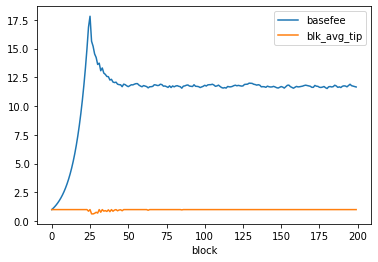

In [5]:
df.plot("block", ["basefee", "blk_avg_tip"])

Notice the increase at the beginning followed by a short drop? At the very beginning, the pool fills up quickly with many users hopeful to get their transactions in with a positive resulting payoff. The basefee increases until users start balking **and** the pool is exhausted. Once exhausted, basefee starts decreasing again to settle at the stationary point where the pool only includes transactions that are invalid given the stationary basefee.

We can see the pool length becoming stationary in the next plot, showing the length of the pool over time.

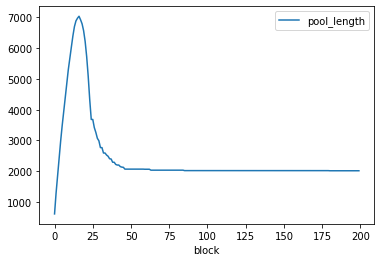

In [6]:
df.plot("block", "pool_length")

The remaining transactions are likely from early users who did not balk even though basefee was increasing, and who were quickly outbid by others.

In [16]:
demand_scenario = [2000 for i in range(200)]
strategies = [Strategy(hash_power=0.6,block_fill_proportion=1),
              Strategy(hash_power=0.4,block_fill_proportion=0)]
(df, user_pool, chain) = simulate(demand_scenario, User1559, strategies=strategies)

0
100


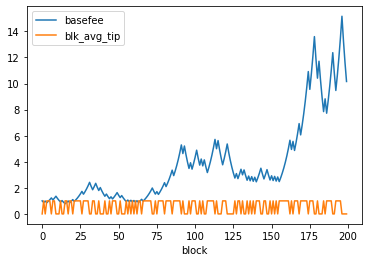

In [17]:
df.plot("block", ["basefee", "blk_avg_tip"])